In [1]:
import sys
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn
import random
import time
import warnings
warnings.filterwarnings('ignore')

from subprocess import check_output

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble
from sklearn import discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

dir="/Users/xinwang/ai/dataset/kaggle/titanic/"
train_file_name='train.csv'
test_file_name='test.csv'

In [2]:
data_raw = pd.read_csv(dir + train_file_name)
data_val = pd.read_csv(dir + test_file_name)

data1 = data_raw.copy(deep=True)
data_cleaner = [data1, data_val]

print('Train columns with null values:\n', data1.isnull().sum())
print('-'*50)
print('Test columns with null values:\n', data_val.isnull().sum())
print('-'*50)
data_raw.describe(include='all')
print('-'*50)

data1.head(4)

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------------------------------------
Test columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
--------------------------------------------------
--------------------------------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [3]:
#### Completing Features
for dataset in data_cleaner:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

drop_columns = ['PassengerId','Cabin','Ticket']
data1.drop(drop_columns, axis=1, inplace=True)
# data_val.drop([drop_columns], axis=1, inplace=True)
    
print(data1.isnull().sum())
print('-'*50)
print(data_val.isnull().sum())
print('-'*50)


#### Creating Features
for dataset in data_cleaner:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize']>1] = 0
    
    dataset['Title'] = dataset['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    
# print(data1['Title'].value_counts())
# print('-'*50)
stat_min = 10
title_names = (data1['Title'].value_counts()< stat_min)
print(title_names.index)

data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x]==True else x)
print(data1['Title'].value_counts())
print('-'*50)

data1.info()
data_val.info()
data1.sample(3)

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
--------------------------------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64
--------------------------------------------------
Index(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Major', 'Mlle', 'Col',
       'Lady', 'Sir', 'Ms', 'Mme', 'Don', 'the Countess', 'Jonkheer', 'Capt'],
      dtype='object')
Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex      

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
765,1,1,"Hogeboom, Mrs. John C (Anna Andrews)",female,51.0,1,0,77.9583,S,2,0,Mrs,"(31.0, 512.329]","(48.0, 64.0]"
267,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,7.7750,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
118,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,247.5208,C,2,0,Mr,"(31.0, 512.329]","(16.0, 32.0]"


In [4]:
label = LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

Target = ['Survived']

data1_x = ['Sex','Pclass','Embarked','Title','SibSp','Parch','Age','Fare','FamilySize','IsAlone']
data1_x_calc = ['Sex_Code','Pclass','Embarked_Code','Title_Code','SibSp','Parch','Age','Fare']
data1_xy = Target + data1_x
print('Original X Y:', data1_xy, '\n')


data1_x_bin = ['Sex_Code','Pclass','Embarked_Code','Title_Code','FamilySize','AgeBin_Code','FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y:', data1_xy_bin, '\n')


data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y:', data1_xy_dummy, '\n')


data1_dummy.head()

Original X Y: ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y: ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y: ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [5]:
print(data1.isnull().sum())
print('-'*50)
print(data1.info())
print('-'*50)


print(data_val.isnull().sum())
print('-'*50)
print(data_val.info())
print('-'*50)

data1.describe(include='all')

Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null 

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
count,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891.000000,891,891.000000,891.000000,891,891,891,891.000000,891.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,891,2,NaN,NaN,NaN,NaN,3,NaN,NaN,5,4,5,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,"West, Miss. Constance Mirium",male,NaN,NaN,NaN,NaN,S,NaN,NaN,Mr,"(7.91, 14.454]","(16.0, 32.0]",NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1,577,NaN,NaN,NaN,NaN,646,NaN,NaN,517,224,525,NaN,NaN,NaN,NaN,NaN
mean,0.383838,2.308642,NaN,NaN,29.361582,0.523008,0.381594,32.204208,NaN,1.904602,0.602694,NaN,NaN,NaN,0.647587,1.536476,2.740741,1.288440,1.497194
std,0.486592,0.836071,NaN,NaN,13.019697,1.102743,0.806057,49.693429,NaN,1.613459,0.489615,NaN,NaN,NaN,0.477990,0.791503,0.896379,0.812038,1.118156
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,7.910400,NaN,1.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000,2.000000,1.000000,0.500000
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,14.454200,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,3.000000,1.000000,1.000000
75%,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,31.000000,NaN,2.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,3.000000,2.000000,2.000000


In [6]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state=0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin],data1[Target], random_state=0)
train1_x_dummy,test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state=0)

print('Data1.shape: {}'.format(data1.shape))
print('Train1.shape: {}'.format(train1_x.shape))
print('Test1.shape: {}'.format(test1_x.shape))

train1_x_bin.head(3)

Data1.shape: (891, 19)
Train1.shape: (668, 8)
Test1.shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2


In [7]:
print(data1[['Sex', 'Survived']].groupby('Sex', as_index=False).mean())
print('*'*50)

for x in data1_x:
    if data1[x].dtype != 'float64':
        print('correlation by ', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*50)
        
print(pd.crosstab(data1['Title'], data1[Target[0]]))

      Sex  Survived
0  female  0.742038
1    male  0.188908
**************************************************
correlation by  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
--------------------------------------------------
correlation by  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
--------------------------------------------------
correlation by  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
--------------------------------------------------
correlation by  Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
--------------------------------------------------
correlation by  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
--------------------------------------------------
correlation by  Parch
   P

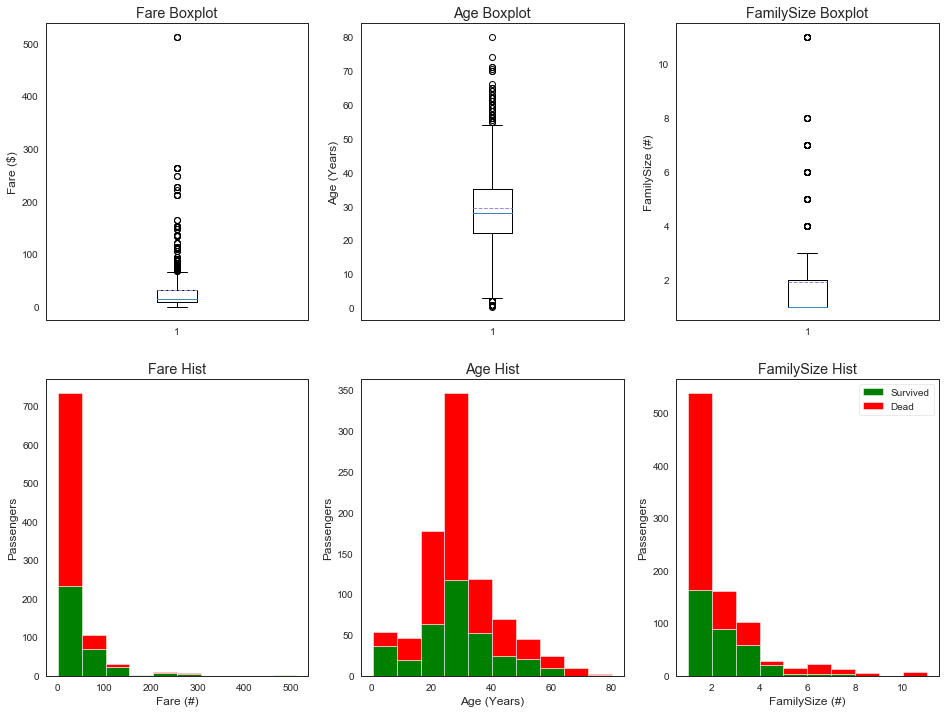

In [8]:
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans=True, meanline=True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(x=data1['Age'], showmeans=True, meanline=True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(x=data1['FamilySize'], showmeans=True, meanline=True)
plt.title('FamilySize Boxplot')
plt.ylabel('FamilySize (#)')


plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']],
        stacked=True, color=['g','r'], label=['Survived','Dead'])
plt.title('Fare Hist')
plt.xlabel('Fare (#)')
plt.ylabel('Passengers')

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']],
        stacked=True, color=['g','r'], label=['Survived','Dead'])
plt.title('Age Hist')
plt.xlabel('Age (Years)')
plt.ylabel('Passengers')


plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']],
        stacked=True, color=['g','r'], label=['Survived','Dead'])
plt.title('FamilySize Hist')
plt.xlabel('FamilySize (#)')
plt.ylabel('Passengers')
plt.legend()

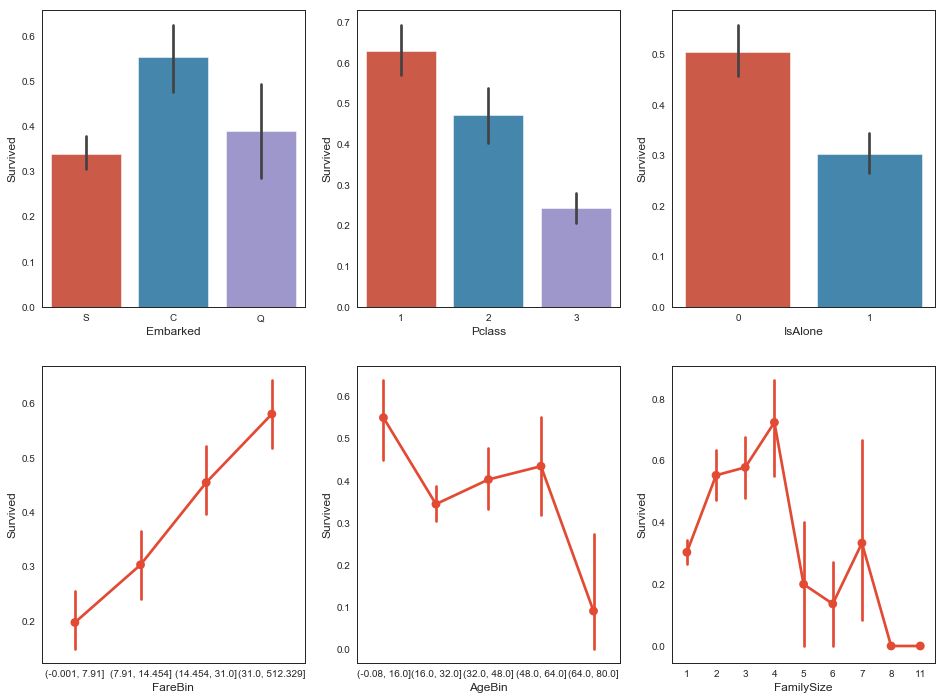

In [9]:
fig, saxis = plt.subplots(2, 3, figsize=(16,12))
sns.barplot(x ='Embarked', y='Survived', data=data1, ax=saxis[0,0])
sns.barplot(x='Pclass', y='Survived', data=data1, ax=saxis[0,1])
sns.barplot(x='IsAlone', y='Survived', data=data1, ax=saxis[0,2])
sns.pointplot(x='FareBin', y='Survived', data=data1, ax=saxis[1,0])
sns.pointplot(x='AgeBin', y='Survived', data=data1, ax=saxis[1,1])
sns.pointplot(x='FamilySize', y='Survived', data=data1, ax=saxis[1,2])


Text(0.5,1,'Pclass & FamilySize comparision')

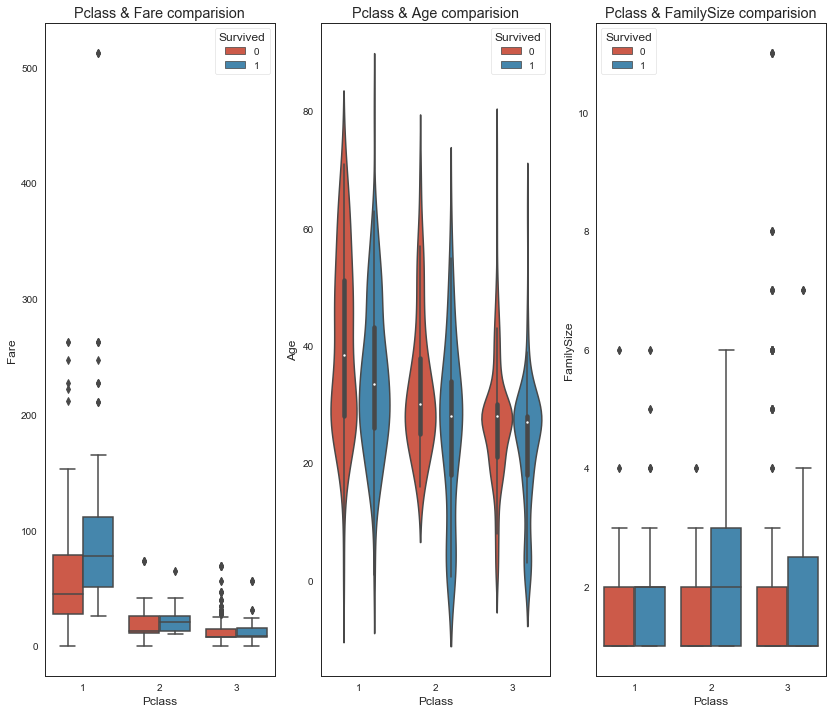

In [10]:
fig, (axis1,axis2,axis3) = plt.subplots(1, 3, figsize=(14,12))

sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=data1, ax=axis1)
axis1.set_title('Pclass & Fare comparision')

sns.violinplot(x='Pclass', y='Age', hue='Survived', data=data1, ax=axis2)
axis2.set_title('Pclass & Age comparision')

sns.boxplot(x='Pclass', y='FamilySize', hue='Survived', data=data1, ax=axis3)
axis3.set_title('Pclass & FamilySize comparision')

Text(0.5,1,'Sex & Survived & IsAlone')

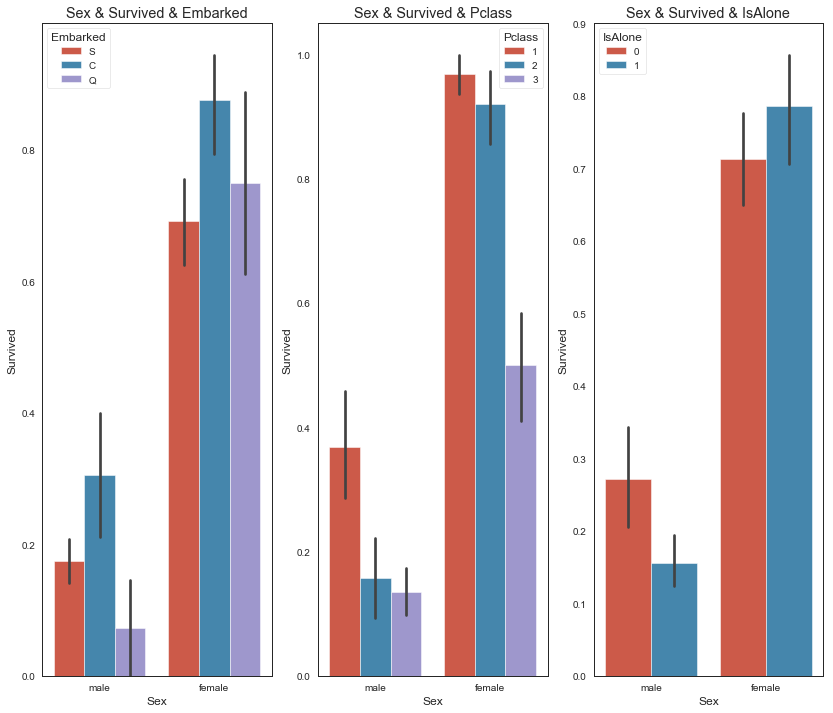

In [11]:
fig, qaxis = plt.subplots(1,3, figsize=(14,12))
sns.barplot(x='Sex', y='Survived', hue='Embarked', data=data1, ax=qaxis[0])
qaxis[0].set_title('Sex & Survived & Embarked')

sns.barplot(x='Sex', y='Survived', hue='Pclass', data=data1, ax=qaxis[1])
qaxis[1].set_title('Sex & Survived & Pclass')

sns.barplot(x='Sex', y='Survived', hue='IsAlone', data=data1, ax=qaxis[2])
qaxis[2].set_title('Sex & Survived & IsAlone')


Text(0.5,1,'Pclass & Survived & Sex')

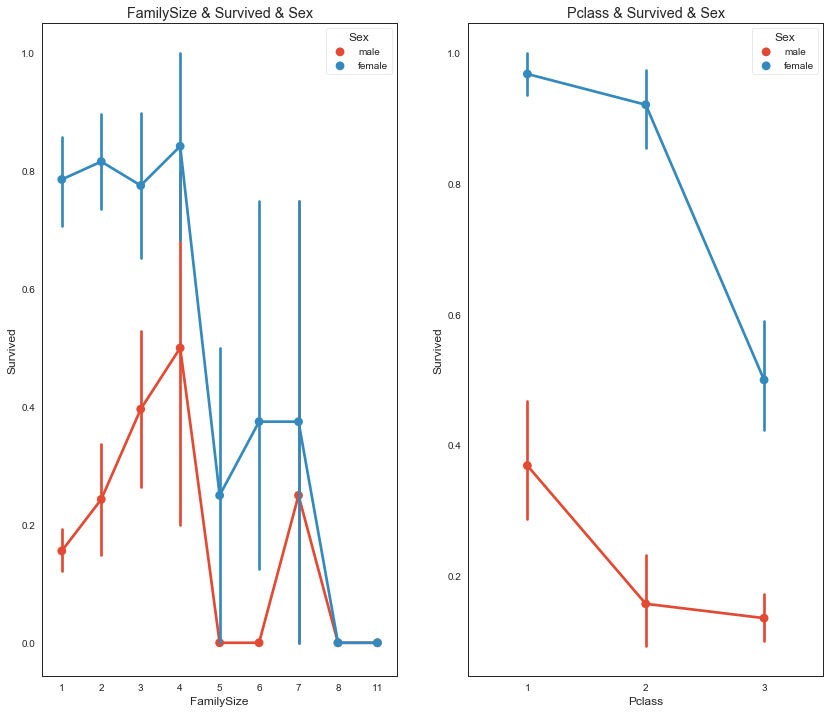

In [12]:
fig, (maxis1, maxis2) = plt.subplots(1, 2, figsize=(14,12))
sns.pointplot(x='FamilySize', y='Survived', hue='Sex', data=data1, ax=maxis1)
maxis1.set_title('FamilySize & Survived & Sex')

sns.pointplot(x='Pclass', y='Survived', hue='Sex', data=data1, ax=maxis2)
maxis2.set_title('Pclass & Survived & Sex')


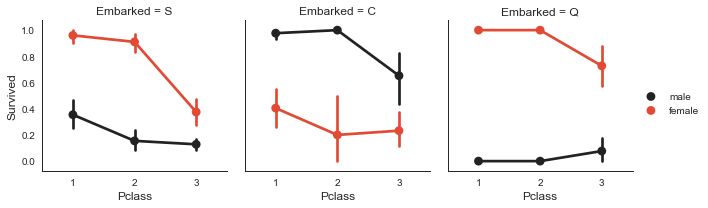

In [13]:
e = sns.FacetGrid(data1, col='Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0)
e.add_legend()

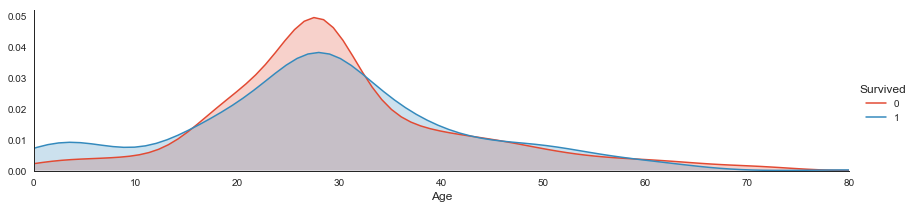

In [14]:
a = sns.FacetGrid(data1, hue='Survived', aspect=4)
a.map(sns.kdeplot, 'Age', shade=True)
a.set(xlim=(0, data1['Age'].max()))
a.add_legend()

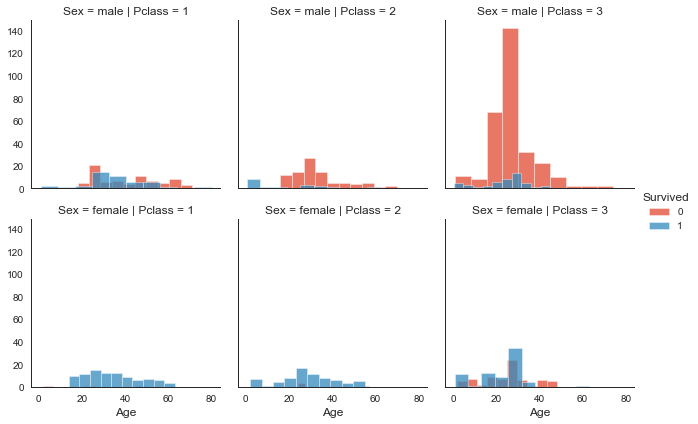

In [15]:
h = sns.FacetGrid(data1, row = 'Sex', col='Pclass', hue='Survived')
h.map(plt.hist, 'Age', alpha=.75)
h.add_legend()

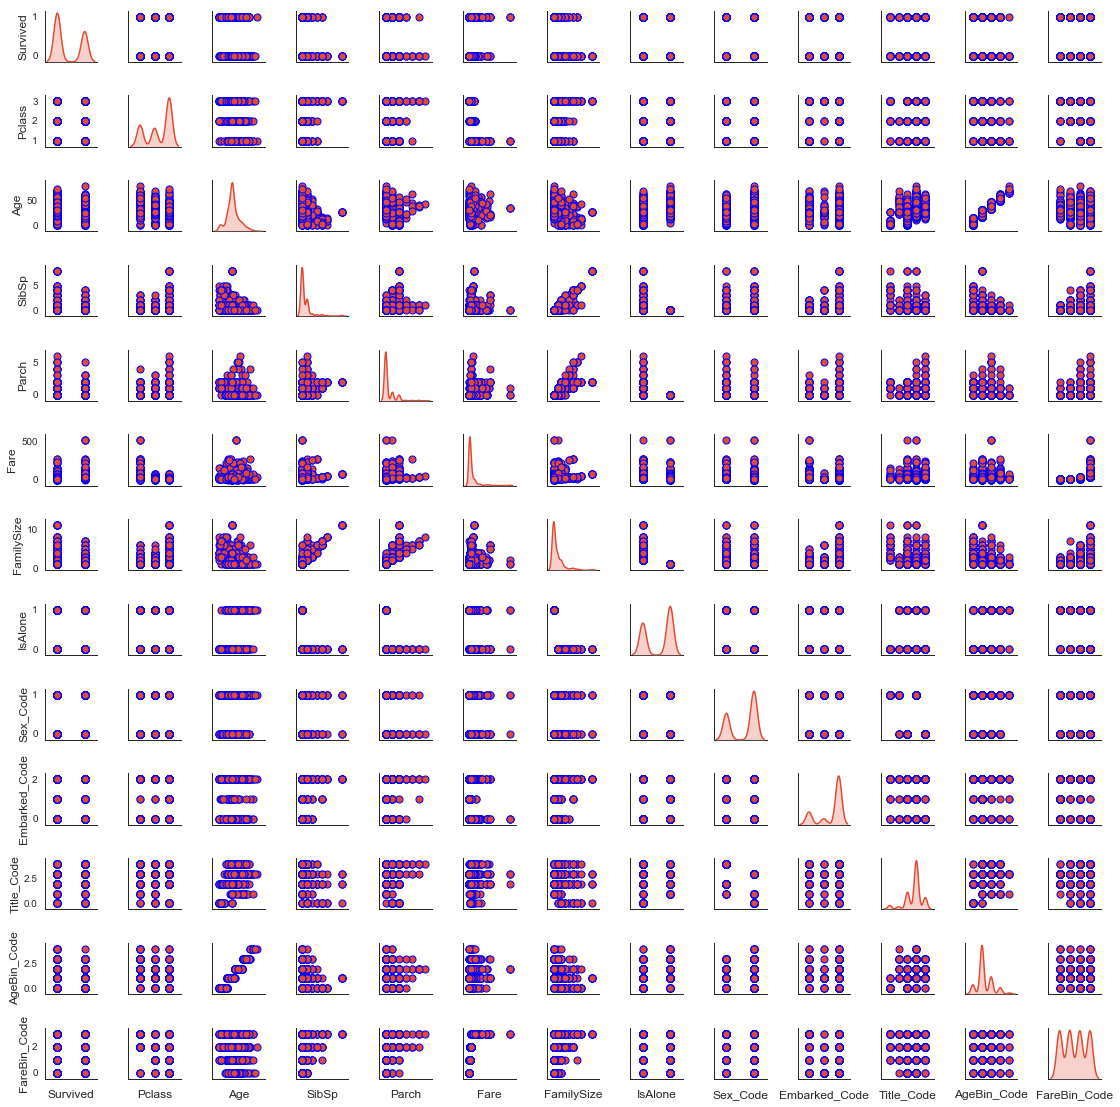

In [16]:
data1.head(3)
pp = sns.pairplot(data1,palette='deep', size=1.2, diag_kind='kde',
                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                  diag_kws=dict(shade=True))
pp.set(xticklabels=[])

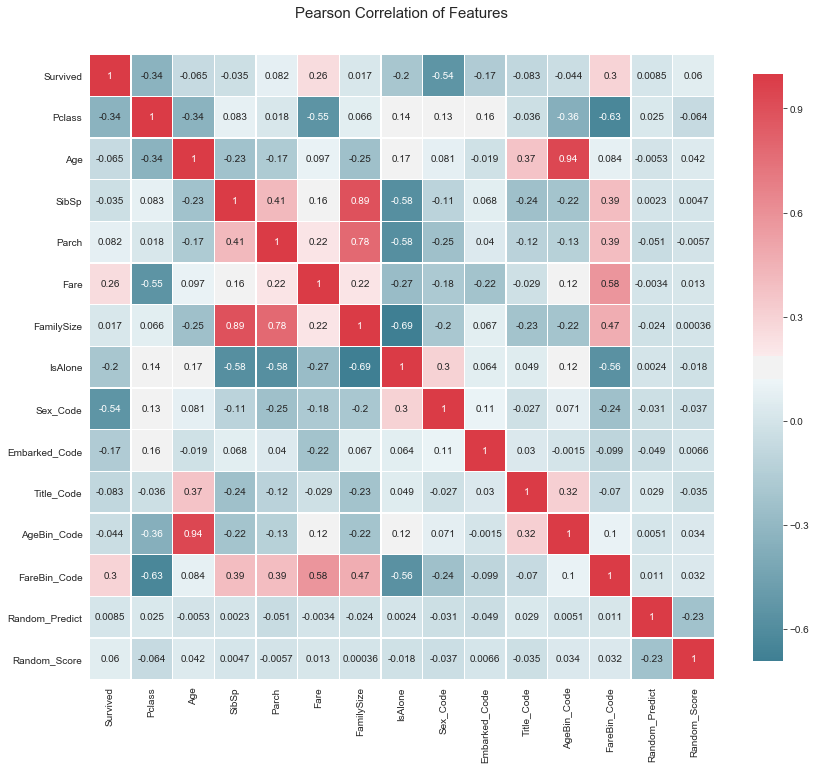

In [32]:
def correlation_heatmap(df):
    _, ax = plt.subplots(figsize=(14,12))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    _ = sns.heatmap(df.corr(),
                   cmap=colormap,
                   square=True,
                   cbar_kws={'shrink':.9},
                   ax=ax,
                   annot=True,
                   linewidths=0.1,
                   vmax=1.0,
                   linecolor='white')
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)
    

In [20]:
MLA=[
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    gaussian_process.GaussianProcessClassifier(),
    
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    neighbors.KNeighborsClassifier(),
    
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    XGBClassifier()
]

cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, 
                                        random_state=0)
MLA_columns = ['MLA name','MLA parameters', 'MLA train accuracy mean', 
               'MLA test accuracy mean','MLA test accuracy 3*std','MLA time']
MLA_compare = pd.DataFrame(columns=MLA_columns)

MLA_predict = data1[Target]

row_index= 0
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], 
                                                  cv=cv_split)
    

    MLA_compare.loc[row_index, 'MLA train accuracy mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA test accuracy mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA test accuracy 3*std'] = cv_results['test_score'].std()*3
    MLA_compare.loc[row_index, 'MLA time'] = cv_results['fit_time'].mean()
        
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name]=alg.predict(data1[data1_x_bin])
    
    row_index +=1
    
MLA_compare.sort_values(by='MLA test accuracy mean', ascending=False, inplace=True)
    
MLA_compare

,MLA name,MLA parameters,MLA train accuracy mean,MLA test accuracy mean,MLA test accuracy 3*std,MLA time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.856367,0.829478,0.0527546,0.0214193
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.0305885
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835768,0.822761,0.0493681,0.0343295
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.822388,0.0649254,0.0148103
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866667,0.822015,0.0529916,0.062638
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.890262,0.820896,0.0625264,0.0176771
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.819403,0.0584238,0.00164735
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.890075,0.814179,0.0656165,0.0156881
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.00156116
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.820412,0.81194,0.0498606,0.0706676


Text(0,0.5,'Algorithm')

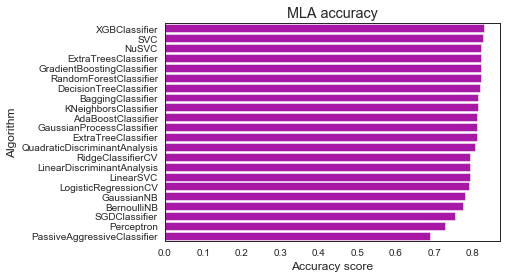

In [21]:
sns.barplot(x='MLA test accuracy mean', y='MLA name', data=MLA_compare, color='m')
plt.title('MLA accuracy')
plt.xlabel('Accuracy score')
plt.ylabel('Algorithm')

In [22]:
for index, row in data1.iterrows():
    if random.random() > 0.5:
        data1.set_value(index, 'Random_Predict', 1)
    else:
        data1.set_value(index, 'Random_Predict', 0)

data1['Random_Score'] = 0
data1.loc[data1['Survived'] == data1['Random_Predict'], 'Random_Score'] = 1
print('Coin flip model accuracy: {:.2f}%'.format(data1['Random_Score'].mean()*100))
print('Coin flip model accuracy: {:.2f}%'.format(100.0*metrics.accuracy_score(data1['Survived'], data1['Random_Predict'])))


pivot_female = data1[data1['Sex'] == 'female'].groupby(['Sex','Pclass','Embarked','FareBin'])['Survived'].mean()
print('Survived Female Decision tree w/Female Node:\n', pivot_female)

pivot_male = data1[data1['Sex'] == 'male'].groupby(['Sex','Title'])['Survived'].mean()
print('Survived Male Decision tree w/Male Node:\n', pivot_male)

Coin flip model accuracy: 49.72%
Coin flip model accuracy: 49.72%
Survived Female Decision tree w/Female Node:
 Sex     Pclass  Embarked  FareBin        
female  1       C         (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (31.0, 512.329]    1.000000
                S         (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.955556
        2       C         (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (7.91, 14.454]     1.000000
                S         (7.91, 14.454]     0.875000
                          (14.454, 31.0]     0.916667
                          (31.0, 512.329]    1.000000
        3       C         (-0.001, 7.91]     1.000000
                          (7.91, 14.454]     0.428571
                          (14.454, 31.0]     0.666667
                Q         (-0.001, 7

In [23]:
def SmartHandmakeDecisionTree(df):
    Model = pd.DataFrame(data={'Predict':[]})

    male_title = ['Master']
    
    for index, row in df.iterrows():
        Model.loc[index, 'Predict'] = 0
        
        if (df.loc[index, 'Sex'] == 'female'):
            Model.loc[index, 'Predict'] =1
        
        if ((df.loc[index, 'Sex'] == 'female') &
           (df.loc[index, 'Pclass'] ==3) &
           (df.loc[index, 'Embarked'] =='S') &
           (df.loc[index, 'Fare'] >8)):
            Model.loc[index, 'Predict'] = 0
        if ((df.loc[index, 'Sex'] == 'male') &
           (df.loc[index, 'Title'] in male_title)):
            Model.loc[index, 'Predict'] =1
        
    return Model
    
Tree_predict = SmartHandmakeDecisionTree(data1)
print('Decision tree model accuracy: {:.2f}%\n'.format(
    metrics.accuracy_score(data1['Survived'], Tree_predict['Predict'])*100.0))

print('Decision tree classification report\n' + 
      str(metrics.classification_report(data1['Survived'],Tree_predict)))
    
    
    

Decision tree model accuracy: 82.04%

Decision tree classification report
             precision    recall  f1-score   support

          0       0.82      0.91      0.86       549
          1       0.82      0.68      0.75       342

avg / total       0.82      0.82      0.82       891



Confusion matrix, without normalization
[[497  52]
 [108 234]]
Normalized confusion Matrix
[[0.91 0.09]
 [0.32 0.68]]


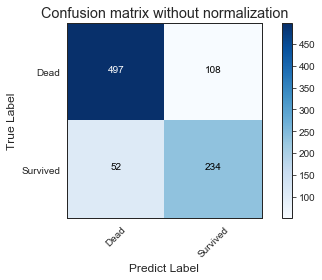

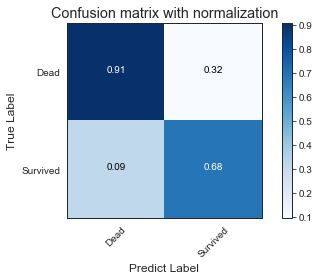

In [24]:
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion Matrix')
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max()/2.0
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[j,i], fmt), horizontalalignment='center',
                color='white' if cm[j, i]>thresh else 'black')
        
        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predict Label')
        

cnf_matrix = metrics.confusion_matrix(data1['Survived'], Tree_predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Confusion matrix with normalization')





In [28]:
dtree = tree.DecisionTreeClassifier(random_state=0)
base_result = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv= cv_split)
dtree.fit(data1[data1_x_bin], data1[Target])

print('Before DT params:', dtree.get_params())
print()
print('Before DT Training w/bin score mean: {:.2f}'.format(base_result['train_score'].mean()*100.))
print('Before DT Test w/bin score mean: {:.2f}'.format(base_result['test_score'].mean()*100.0))
print('Before DT Test w/bin score 3*std: {:.2f}'.format(base_result['test_score'].std()*3*100.))
print('-'*50)


param_grid = {
    'criterion':['gini','entropy'],
    'max_depth': [2,4,6,8,10, None],
    'min_samples_split':[2, 5, 10, .3 ,.5],
    'min_samples_leaf': [1, 5, 10, .3, .5],
    'random_state':[0]
}


tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(),
                                          param_grid=param_grid,
                                          scoring='roc_auc', cv=cv_split)
tune_model.fit(data1[data1_x_bin], data1[Target])


print('After DT params:', tune_model.best_params_)
print()
print('After DT Training w/bin score mean: {:.2f}'.format(
    tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100.))
print('After DT Test w/bin score mean: {:.2f}'.format(
    tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100.0))
print('After DT Test w/bin score 3*std: {:.2f}'.format(
    tune_model.cv_results_['std_test_score'][tune_model.best_index_]*3*100.))
print('-'*50)




# predictions = tune_model.best_estimator_.predict(data_val[data1_x_bin])

# pred_df = pd.DataFrame({
#     'PassengerId': data_val['PassengerId'],
#     'Survived': predictions
# })

# pred_df.to_csv('handmake_dt_submissions.csv', index=False)

Before DT params: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}

Before DT Training w/bin score mean: 89.51
Before DT Test w/bin score mean: 82.09
Before DT Test w/bin score 3*std: 5.57
--------------------------------------------------
After DT params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2, 'random_state': 0}

After DT Training w/bin score mean: 89.25
After DT Test w/bin score mean: 87.68
After DT Test w/bin score 3*std: 6.00
--------------------------------------------------


In [27]:
print('Before DT RFE training shape old:', data1[data1_x_bin].shape)
print('Before DT RFE training columns old:', data1[data1_x_bin].columns.values)

print('Before DT RFE Training w/bin score mean: {:.2f}'.format(base_result['train_score'].mean()*100.))
print('Before DT RFE Test w/bin score mean: {:.2f}'.format(base_result['test_score'].mean()*100.0))
print('Before DT RFE Test w/bin score 3*std: {:.2f}'.format(base_result['test_score'].std()*3*100.))
print('-'*50)


dtree_rfe = feature_selection.RFECV(dtree, step=1, scoring='accuracy', cv=cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target], cv=cv_split)

print('After DT RFE training shape old:', data1[X_rfe].shape)
print('After DT RFE training columns old:', data1[X_rfe].columns.values)

print('After DT RFE Training w/bin score mean: {:.2f}'.format(rfe_results['train_score'].mean()*100.))
print('After DT RFE Test w/bin score mean: {:.2f}'.format(rfe_results['test_score'].mean()*100.0))
print('After DT RFE Test w/bin score 3*std: {:.2f}'.format(rfe_results['test_score'].std()*3*100.))
print('-'*50)


rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(),
                                             param_grid=param_grid,
                                             scoring='accuracy',
                                             cv=cv_split)
rfe_tune_model.fit(data1[X_rfe], data1[Target])

print('After DT RFE tuned params', rfe_tune_model.best_params_)

print('After DT RFE tuned Training w/bin score mean: {:.2f}'.format(
    rfe_tune_model.cv_results_['mean_train_score'][rfe_tune_model.best_index_]*100.))
print('After DT RFE tuned Test w/bin score mean: {:.2f}'.format(
    rfe_tune_model.cv_results_['mean_test_score'][rfe_tune_model.best_index_]*100.0))
print('After DT RFE tuned Test w/bin score 3*std: {:.2f}'.format(
    rfe_tune_model.cv_results_['std_test_score'][rfe_tune_model.best_index_]*3*100.))
print('-'*50)



Before DT RFE training shape old: (891, 7)
Before DT RFE training columns old: ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
Before DT RFE Training w/bin score mean: 89.51
Before DT RFE Test w/bin score mean: 82.09
Before DT RFE Test w/bin score 3*std: 5.57
--------------------------------------------------
After DT RFE training shape old: (891, 6)
After DT RFE training columns old: ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
After DT RFE Training w/bin score mean: 88.16
After DT RFE Test w/bin score mean: 83.06
After DT RFE Test w/bin score 3*std: 6.22
--------------------------------------------------
After DT RFE tuned params {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'random_state': 0}
After DT RFE tuned Training w/bin score mean: 86.61
After DT RFE tuned Test w/bin score mean: 83.69
After DT RFE tuned Test w/bin score 3*std: 5.28
----------------------

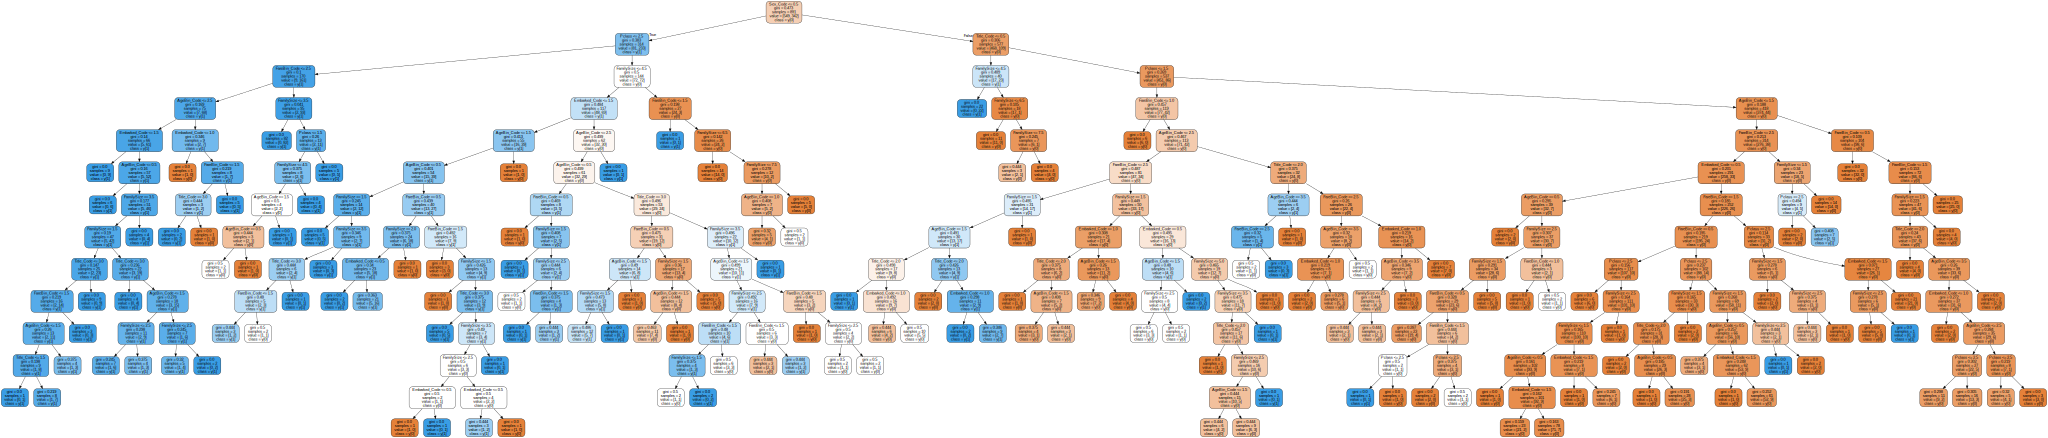

In [30]:
import graphviz

dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names=data1_x_bin, 
                                class_names=True, 
                                filled=True, 
                                rounded=True)
graph = graphviz.Source(dot_data)

graph

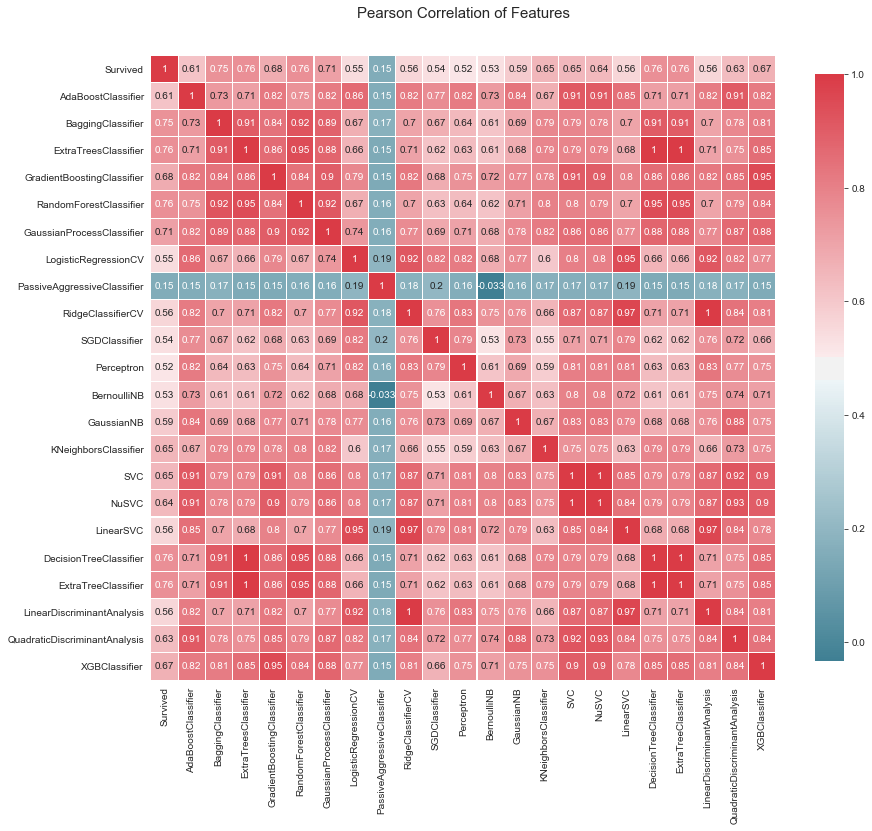

In [33]:
correlation_heatmap(MLA_predict)

In [35]:
vote_est = [
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc',ensemble.GradientBoostingClassifier()),
    ('rfc',ensemble.RandomForestClassifier()),
    
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    ('lr', linear_model.LogisticRegressionCV()),
    
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    ('knn',neighbors.KNeighborsClassifier()),
    
    ('svc',svm.SVC(probability=True)),
    
    ('xgb',XGBClassifier())
]

vote_hard = ensemble.VotingClassifier(estimators = vote_est, voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin], data1[Target], cv=cv_split)
vote_hard.fit(data1[data1_x_bin], data1[Target])

print('Hard Voting Training w/bin score mean: {:.2f}'.format(vote_hard_cv['train_score'].mean()*100.))
print('Hard Voting Test w/bin score mean: {:.2f}'.format(vote_hard_cv['test_score'].mean()*100.0))
print('Hard Voting Test w/bin score 3*std: {:.2f}'.format(vote_hard_cv['test_score'].std()*3*100.))
print('-'*50)


vote_soft = ensemble.VotingClassifier(estimators = vote_est, voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin], data1[Target], cv=cv_split)
vote_soft.fit(data1[data1_x_bin], data1[Target])

print('Soft Voting Training w/bin score mean: {:.2f}'.format(vote_soft_cv['train_score'].mean()*100.))
print('Soft Voting Test w/bin score mean: {:.2f}'.format(vote_soft_cv['test_score'].mean()*100.0))
print('Soft Voting Test w/bin score 3*std: {:.2f}'.format(vote_soft_cv['test_score'].std()*3*100.))
print('-'*50)




Hard Voting Training w/bin score mean: 86.63
Hard Voting Test w/bin score mean: 82.24
Hard Voting Test w/bin score 3*std: 4.16
--------------------------------------------------
Soft Voting Training w/bin score mean: 87.12
Soft Voting Test w/bin score mean: 82.50
Soft Voting Test w/bin score 3*std: 4.14
--------------------------------------------------
